# 0. Dependencies and notebook settings

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#to create a inline image when using jupyter notebook with higher quality using seaborn style
%matplotlib inline  
%config InlineBackend.figure_format = 'retina' #or svg
plt.style.use('seaborn')

# Data Description

Two series of data are used in this study. A TSP file containing 16 and 96 data points each in `Swarm016.tsp` and `Swarm096.tsp`. These files represents datapoints in 2 Dimensional space.

In [4]:
data16 = pd.read_csv('Swarm016.tsp',delimiter =" ", index_col=0 )
data96 = pd.read_csv('Swarm096.tsp',delimiter =" ", index_col=0 )

### Data visualizaiton function
In order to make it easier to use in repetitive way, I wrap the scatter steps (using matplotlib) as follow : 

In [132]:
def ib_scatterhs_2d(datas,axes,titles,dpi=50
                    ,suptitle="Data Visualization"
                    ,figsize=(0,0), route=[]
                    ,node_color='k',edge_color='k',s=30
                    ,verbouse=False, sharex=False, sharey=False, print_route=False, ):
    
    if(axes == 1):
        fig, ax = plt.subplots(dpi=dpi, figsize=figsize,sharex=sharex, sharey=sharey)
        ax.scatter(datas[0]['X'], datas[0]['Y'], alpha=1, color=node_color,s=s, label="city",zorder=2)
        ax.set_title(titles[0]); ax.legend(loc=2)
        if verbouse:
            xmax,xmin,ymax,ymin = np.max(datas[0]['X']),np.min(datas[0]['X']),np.max(datas[0]['Y']),np.min(datas[0]['Y'])
            x_off, y_off = (xmax-xmin)*0.008, (ymax-ymin)*0.02
            for j in range(len(datas[0])):
                ax.annotate(j, (datas[0]['X'].iloc[j]-x_off, datas[0]['Y'].iloc[j]+y_off))
        if print_route:
            ax.plot(datas[0]['X'], datas[0]['Y'],color=edge_color,lw=1.5, zorder=1)
                    
    else:
        fig, axes = plt.subplots(1, axes, dpi=dpi, figsize=figsize,sharex=sharex, sharey=sharey)
        for i, ax in enumerate(axes):
            ax.scatter(datas[i]['X'], datas[i]['Y'], alpha=1, color=node_color,s=s, label="city", zorder=2)
            ax.set_title(titles[i]); ax.legend(loc=2)
            if verbouse:
                xmax,xmin,ymax,ymin = np.max(datas[i]['X']),np.min(datas[i]['X']),np.max(datas[i]['Y']),np.min(datas[i]['Y'])
                x_off, y_off = (xmax-xmin)*0.008, (ymax-ymin)*0.02
                for j in range(len(datas[i])):
                    ax.annotate(j, (datas[i]['X'].iloc[j]-x_off, datas[i]['Y'].iloc[j]+y_off))
            if print_route:
                ax.plot(datas[i]['X'], datas['Y'][i],color=edge_color,lw=1.5, zorder=1)
                    
    fig.suptitle(suptitle, fontsize=24)
    
#     plt.scatter(datas['X'], datas['Y'],s=80,color='b', zorder=1)
#     plt.plot(datas['X'], datas['Y'],color='0.2',lw=1.5, zorder=2
         
    plt.show()

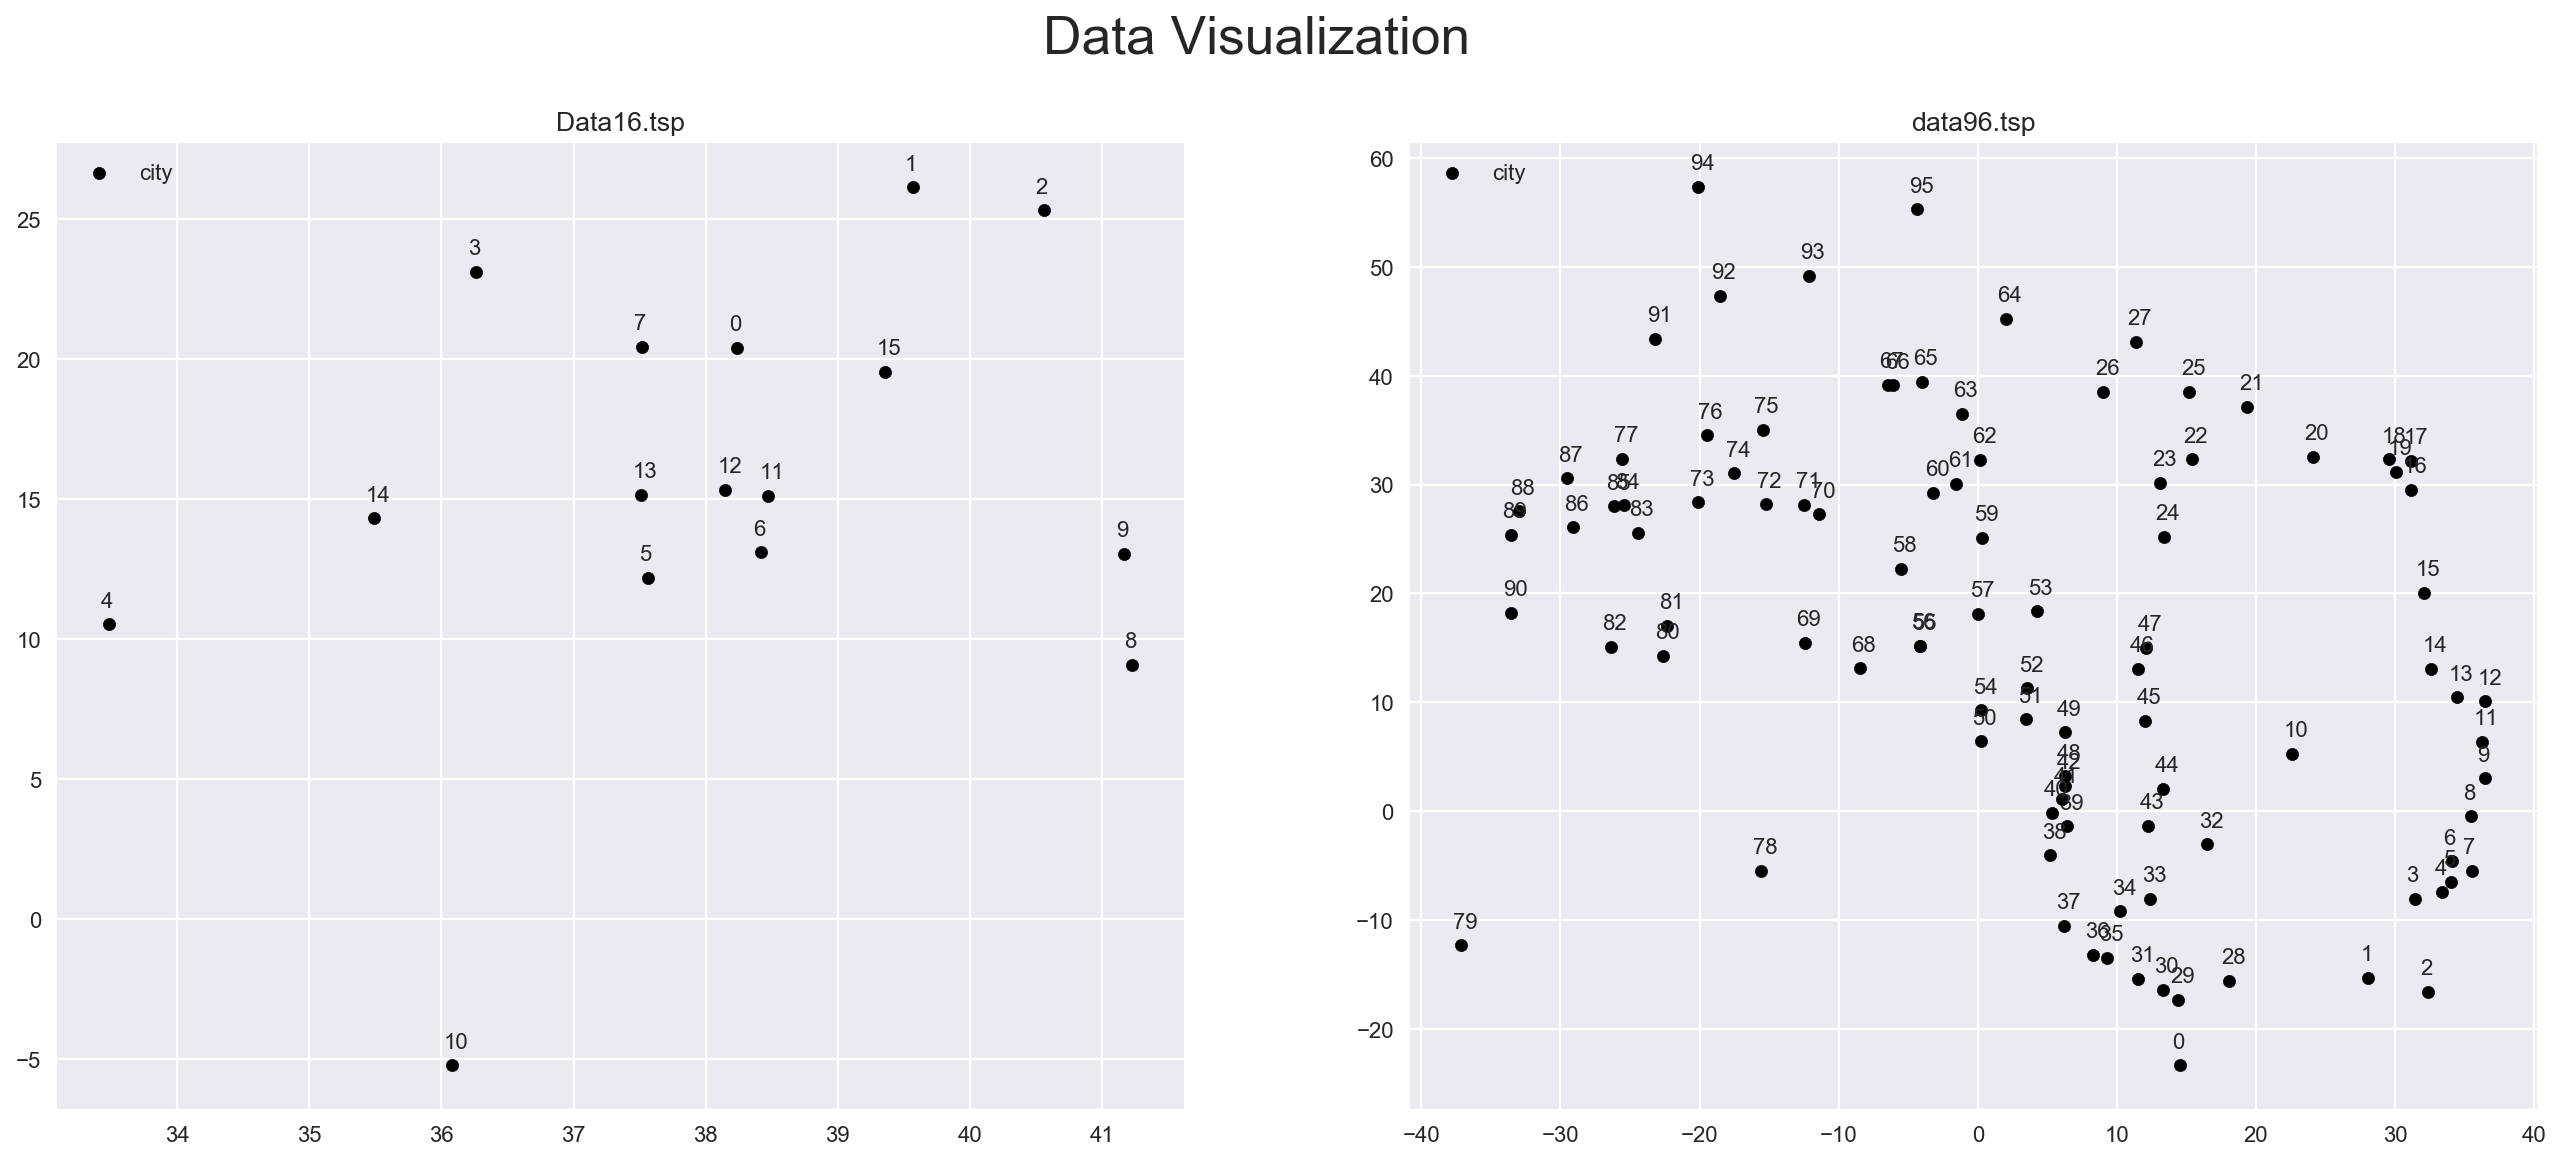

In [133]:
datas = [data16, data96]
axes = 2
titles = ['Data16.tsp', 'data96.tsp']
ib_scatterhs_2d(datas,axes,titles,dpi=80,figsize=(20,8),verbouse=True)

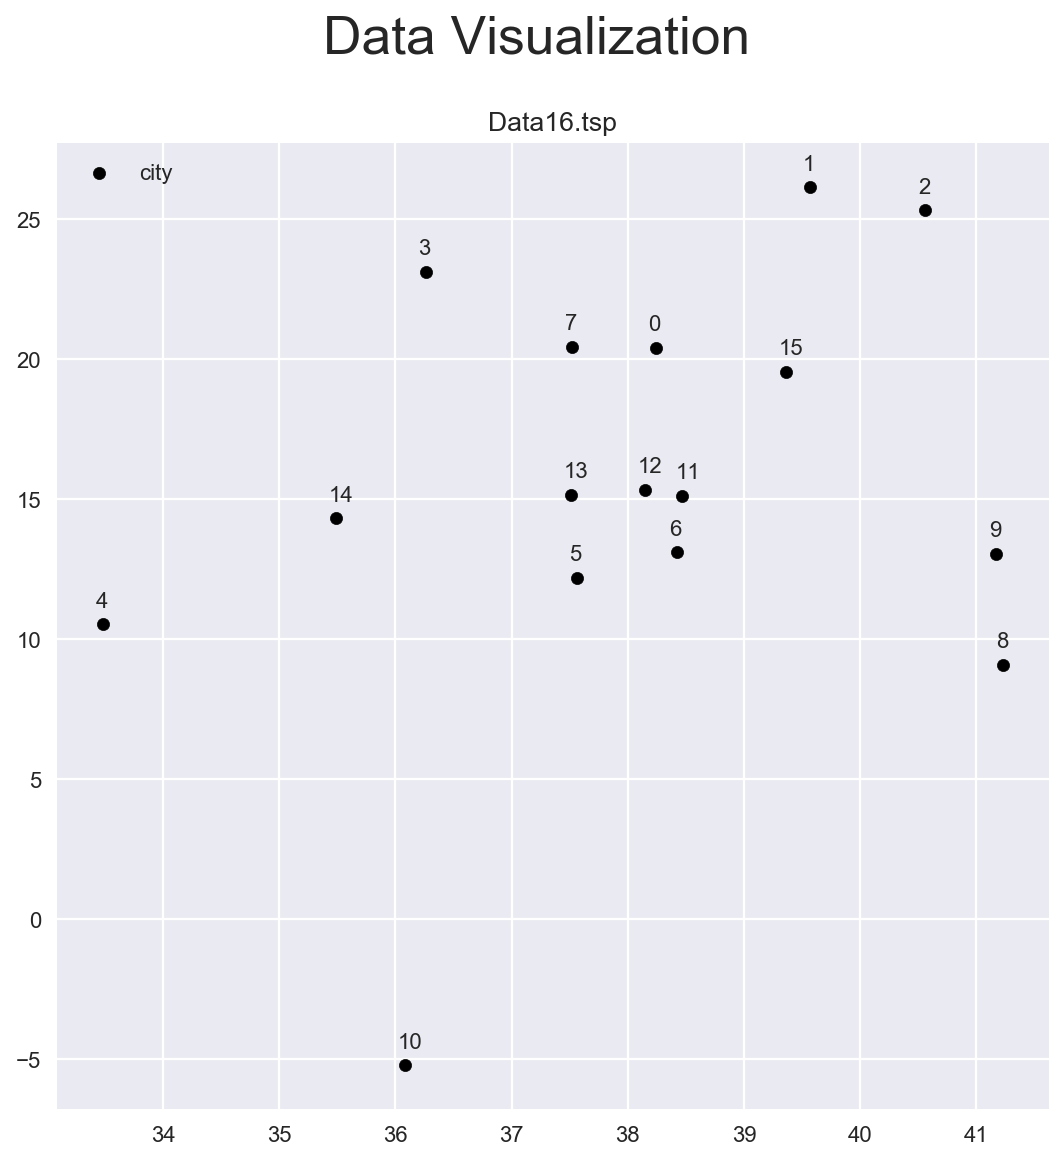

In [134]:
datas = [data16]
axes = 1
titles = ['Data16.tsp']
ib_scatterhs_2d(datas,axes,titles,dpi=80,figsize=(8,8),verbouse=True)

# Solution Model


# Sparse Matrix of Distance

### Method #1 : Use 3rd party library : Scipy
*[See documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance_matrix.html)*

In [87]:
from scipy.spatial import distance_matrix
dist_matrix_16 = distance_matrix(data16.values,data16.values, p=2) 
dist_matrix_96 = distance_matrix(data96.values,data96.values, p=2) 

In [88]:
print(dist_matrix_16.shape, dist_matrix_96.shape)
print(type(dist_matrix_16), type(dist_matrix_96))

(16, 16) (96, 96)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


### Method #2 : Own function

In [89]:
# Create function 
def ib_distance_matrix(matrix1, matrix2, p=2):
    """
    INPUT : 
        - Matrix1 
        - Matrix 2
        - p : integer, p-norm distance. Default is 2 (euclidian distance)
    """
    dist= lambda p1,p2 :((np.absolute(p1-p2))**p).sum()**(1/p)
    dist_matrix = np.asarray([[dist(p1, p2) for p2 in matrix2] for p1 in matrix1])
    
    return dist_matrix

In [90]:
dm1 = distance_matrix(data16.values,data16.values,p=2) 
dm2 = ib_distance_matrix(data16.values,data16.values,p=2)
(dm1==dm2).mean() == 1 #if return True, means that dm1 == dm2

True

### Performance measure

In [91]:
def my_func():
    return ib_distance_matrix(data16.values,data16.values,p=2)
def not_my_func():
    return distance_matrix(data16.values,data16.values,p=2) 

In [92]:
import timeit
n = [1,10,100,1000]
cmpr = []
for i in n:
    cmpr.append([timeit.timeit(my_func, number=i) , timeit.timeit(not_my_func, number=i), i])
cmpr = np.asarray(cmpr)

In [93]:
cmpr

array([[1.62726119e-03, 8.42667665e-04, 1.00000000e+00],
       [1.92541463e-02, 8.00791073e-04, 1.00000000e+01],
       [1.39379128e-01, 3.23634951e-03, 1.00000000e+02],
       [1.53685199e+00, 2.88533675e-02, 1.00000000e+03]])

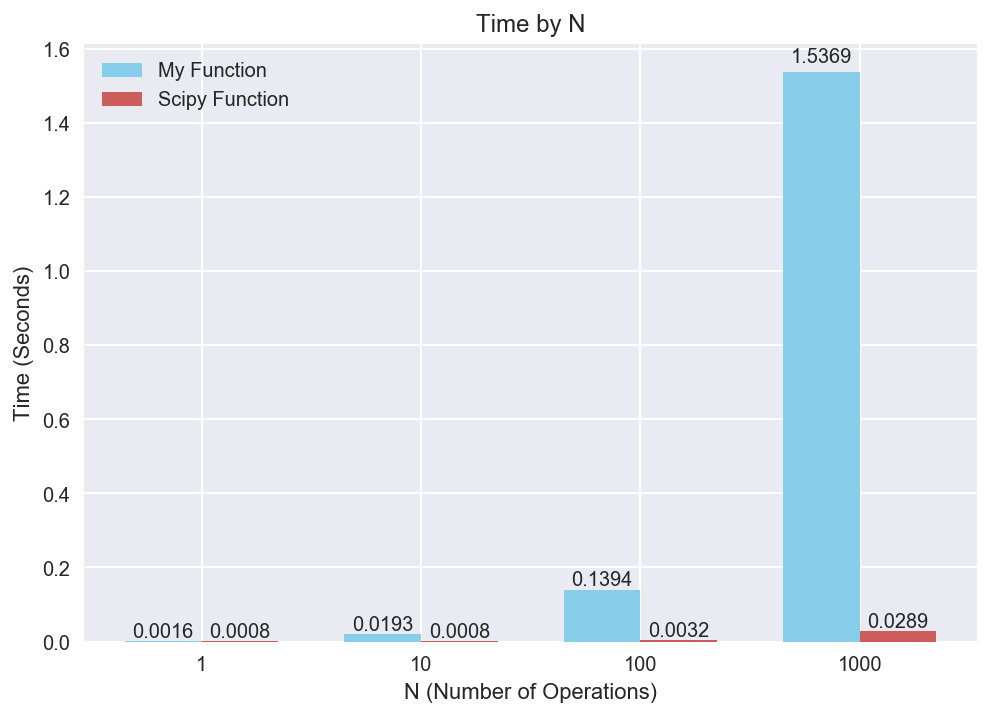

In [94]:
ind = np.arange(len(cmpr[:,0]))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, np.around(tuple(cmpr[:,0]), decimals=4), width, color='SkyBlue', label='My Function')
rects2 = ax.bar(ind + width/2, np.around(tuple(cmpr[:,1]), decimals=4), width, color='IndianRed', label='Scipy Function')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (Seconds)')
ax.set_xlabel('N (Number of Operations)')
ax.set_title('Time by N')
ax.set_xticks(ind)
ax.set_xticklabels(('1', '10', '100', '1000'))
ax.legend()
def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.
    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """
    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')
autolabel(rects1, "center")
autolabel(rects2, "center")

plt.show()

# Pheromone Matrices

Pheromone matrix is square shape of N matrix (same as distance matrix) that contains a pheromone of specific path between two nodes or city. By the inis


In [95]:
def new_pherm_matrix(n,value):
    return np.full((n,n), value)

In [96]:
#===== Testing =======#
new_pherm_matrix(16,0.01)

array([[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.

# Hyper Parameter and Variables
### Hyper Parameter: 
- $N$ , Representing number of ants
- $NC$ , Representing number of cycles
- $\alpha, \beta$, Representing importance level of pheromone and visibility respectively
- $1-\rho$, Representing Evaporation Coefficient
- $Q$, a constant

### Variables:
- $\tau_{ij}(t)$, Representing Pheromones between $city_i$ and $city_j$ on time $t$
- $\Delta\tau_{ij}$, Representing addition of pheromones between $city_i$ and $city_j$ if any ant(s) passed the path
- 

# Objective Function
(Will be implemented **inside** route generation function)

In [159]:
def cost(route,distance_matrix, verbouse = False):
    """
    INPUT :
        Route : a list of visited city sequentially (included first node as final destination)
        distance_matrix  : sparse matrix that contains distance between cities
        verbouse : boolean value to print the information while running
    OUTPUT 
        a float number representing the distance of the route
    """
    dist = 0
    for i in range(len(route)-1):
        dist += distance_matrix[route[i],route[i+1]]
        if (verbouse):
            print ("step", i, "city", route[i], "to", route[i+1], ", Ditance = ", dist)
    return dist

In [160]:
## Testing
r = [1,2,3,4]
cost(r,dist_matrix_16)

19.00552053789265

# Route Finding

### next route probability

In [161]:
def nr_prob(current_node,allowed_nodes, distances, pheromones, alpha, beta, verbouse = False):
    
    p = []
    sigma_p = 0
    
    for i in allowed_nodes:
        prob = pheromones[current_node, i]**alpha + (1/distances[current_node, i])**beta
        p.append(prob)
        sigma_p += prob
        if verbouse:
            print("{p1}->{p2} Distance : {d}, probability: {prb}"
                  .format(p1=current_node,p2=i, d=distances[current_node,i], prb=prob))
    
    p = np.asarray(p) / sigma_p
    next_node = allowed_nodes[np.argmax(p)]
    
    return next_node, distances[current_node,next_node]

In [162]:
## test next route probability
current_node = 0
allowed_node = [1,2,3,4]
dist_matrix_16 = distance_matrix(data16.values,data16.values, p=2) 
dist_matrix_96 = distance_matrix(data96.values,data96.values, p=2)
phr_matrix_16 = new_pherm_matrix(16,0.01)
alpha = 15
beta = 20

print(nr_prob(current_node,allowed_node, dist_matrix_16, phr_matrix_16, alpha, beta, verbouse=True))

0->1 Distance : 5.882329470541408, probability: 4.0645557465489816e-16
0->2 Distance : 5.421475813835195, probability: 2.078018965947943e-15
0->3 Distance : 3.3481935427928913, probability: 3.1899869765294885e-11
0->4 Distance : 10.966859167510089, probability: 1.578900169118309e-21
(3, 3.3481935427928913)


In [163]:
def Generate_tour(init_node,nodes, distance_matrix, pheromone_matrix, alpha, beta, verbouse = False):
    """
    INPUT :
        -Init_node : initial node to start the tour
        -nodes : list, all nodes available in the map (excluding initial node)
        -distance_matrix : matrix
        -pheromone_matrix
        -alpha
        -beta
    Output : 
        -list containing order of visited city as route (including initial node as final destination) 
        -cost of the tour
    """
    
    tabu_list = nodes
    route = [init_node]
    total_bounce = len(tabu_list)
    total_dist = 0
    
    if verbouse : 
        print("Start Generating tour for {a} cities from city {b} ".format(a=total_bounce+1, b=init_node))
    
    for i in range(total_bounce):
        next_node, dist = nr_prob(route[-1],tabu_list, distance_matrix, pheromone_matrix, alpha, beta)
        tabu_list.remove(next_node)
        route.append(next_node)
        total_dist += dist
        if verbouse : 
            print("Bounce #{no}: {p1}->{p2} (Dist = {d}) "
                  .format(no=i+1, p1=route[-2], p2=next_node
                  , d=distance_matrix[route[-2],route[-1]] ))
            
    route.append(init_node)
    total_dist += distance_matrix[route[-2],route[-1]]
    if verbouse : 
        print("Last Bounce: {p1}->{p2} (Dist = {d}) "
              .format(no=i+1, p1=route[-2], p2=route[-1]
              , d=distance_matrix[route[-2],route[-1]] ))
    
    return route, total_dist
    

In [167]:
## test route probability
current_node = 0
allowed_node = list(range(16)); allowed_node.remove(current_node)
dist_matrix_16 = distance_matrix(data16.values,data16.values, p=2) 
dist_matrix_96 = distance_matrix(data96.values,data96.values, p=2)
phr_matrix_16 = new_pherm_matrix(16,0.01)
alpha = 15
beta = 20
route, total_dist = Generate_tour(current_node,allowed_node, dist_matrix_16, phr_matrix_16, alpha, beta
                                  , verbouse=True)
print("Final Route", route, "distance : ",total_dist)

Start Generating tour for 16 cities from city 0 
Bounce #1: 0->7 (Dist = 0.7202777242147631) 
Bounce #2: 7->15 (Dist = 2.039607805437112) 
Bounce #3: 15->12 (Dist = 4.380433768475446) 
Bounce #4: 12->11 (Dist = 0.3883297567789516) 
Bounce #5: 11->13 (Dist = 0.9608329719571459) 
Bounce #6: 13->14 (Dist = 2.1915519615103776) 
Bounce #7: 14->5 (Dist = 2.9701515112869252) 
Bounce #8: 5->6 (Dist = 1.259364919314493) 
Bounce #9: 6->9 (Dist = 2.750654467576762) 
Bounce #10: 9->8 (Dist = 3.9504556699196116) 
Bounce #11: 8->4 (Dist = 7.882645495009908) 
Bounce #12: 4->3 (Dist = 12.883508838821824) 
Bounce #13: 3->1 (Dist = 4.4874268796271215) 
Bounce #14: 1->2 (Dist = 1.2918978287774932) 
Bounce #15: 2->10 (Dist = 30.85694897425862) 
Last Bounce: 10->0 (Dist = 25.720857295199167) 
Final Route [0, 7, 15, 12, 11, 13, 14, 5, 6, 9, 8, 4, 3, 1, 2, 10, 0] distance :  104.73494586816572


In [156]:
cost(route, dist_matrix_16)

104.73494586816572

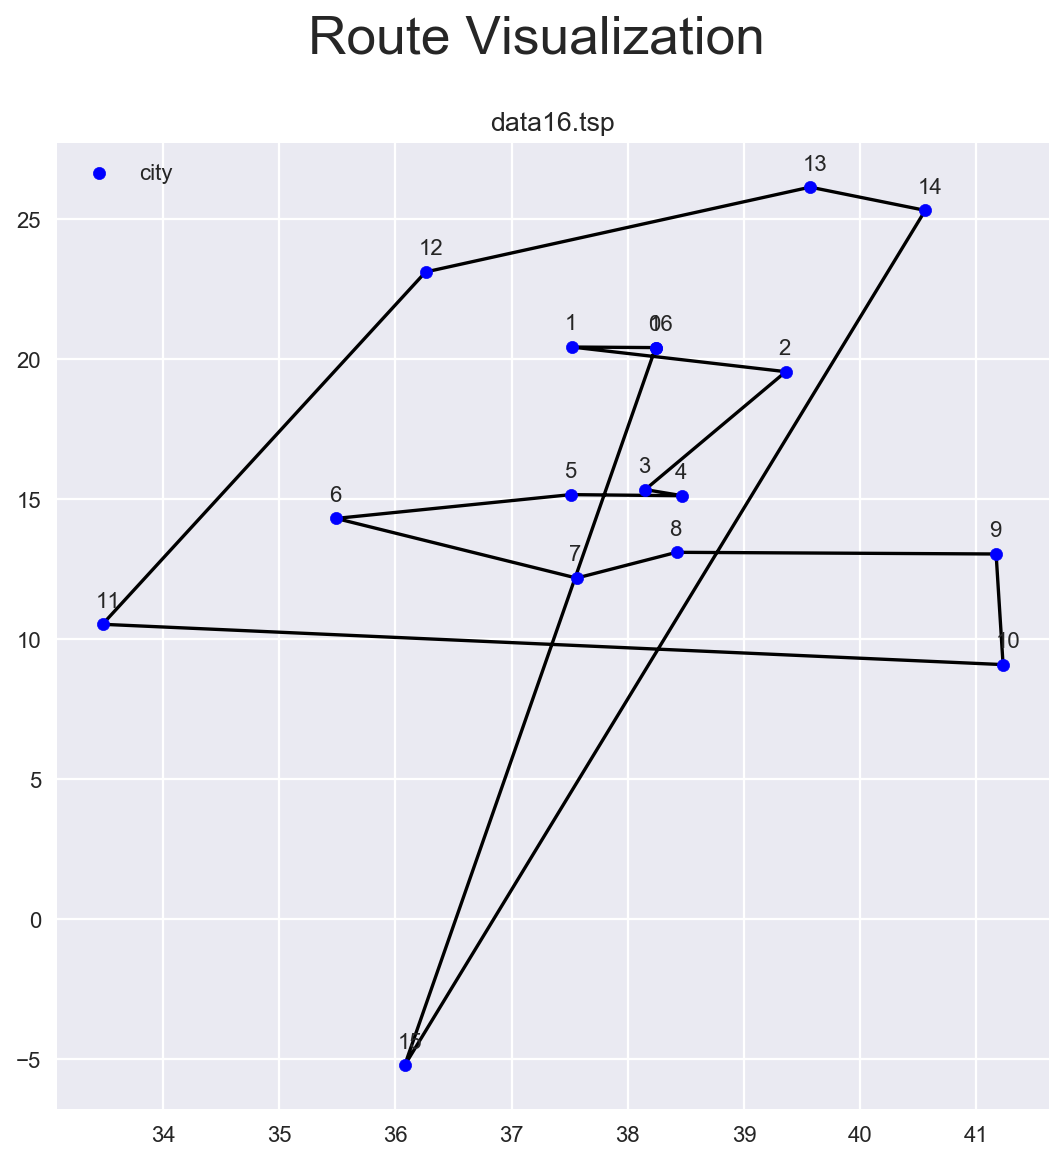

In [144]:
datas = [data16.iloc[route]]
axes = 1
titles = ["data16.tsp"]
ib_scatterhs_2d(datas,axes,titles,dpi=80,node_color='b'
                ,figsize=(8,8),route=route, suptitle="Route Visualization"
                , print_route=True, verbouse = True)

# Pheromone update

$\tau_{ij}(t+n) = \rho\ \tau_{ij}(t) + \Delta\tau_{ij}$,

In [146]:
pheromones16 = new_pherm_matrix(16,0.01)
routes = [route]
routes_cost = cost(routes)
    for route in routes:
        

In [ ]:
# bikin rute dari n semut
N_ant = 10
N_cycle = 10

# Main Algorithm

In [ ]:
#1. Inisialisasi 
t = 0
NC = 0

#2. Loop

#3

# Coba Coba


# Brute force

In [ ]:
import itertools
routes = list(itertools.permutations(list(np.arange(16))))

In [ ]:
list(np.arange(16))